## How do school discipline disparities in New York compare to California when aggregated to the state-level?

### Intern Final Project, Sri Ramesh, Spring 2021, New York Office of the Attorney General (OAG), Research and Analytics Department (RAD)

This notebook implements the code to answer the research question above: How do school discipline disparities in New York compare to California when aggregated to the state-level? All data used in the code below can be found open-source on the California Department of Education website: 

* Data downloadables: https://www.cde.ca.gov/ds/ad/filessd.asp
* Data dictionary: https://www.cde.ca.gov/ds/ad/fssd.asp

The following 10 text files (.txt) from this website were used:

* suspension20
* suspension19
* suspension18
* suspension17
* suspension16
* suspension15
* suspension14
* suspension13
* suspension12
* suspension11

These data sets represent suspensions data over 10 school years: 2011-12 to 2019-20.


## Read, merge, and clean disaparate time series datasets into a master panel dataset representing all school disciplines in California from 2011-2020

The code below does the following:

1. Defines a custom function used to subset the data downloaded in the earlier step by race/ethnicity subgroups
2. Merges disaparate datasets for each school year into a time series dataset for each race/ethnicity subgroup
3. Merges together all race/ethnicity subsets to generate one master, panel dataset representing all disciplines in California for the school years 2011-12 to 2019-20


In [1]:
import pandas as pd

# define function to subset the downloaded data bove

def subset_edu_data(file_name):
    
    # read in each file iteratively
    x = pd.read_csv(file_name, delimiter = "\t", encoding='latin-1')
    x = x.drop(['DistrictCode', 'SchoolCode', 'DistrictName', 'SchoolName'],axis=1) # drop columns with no data in them
    
    # include data from all schools regardless of charter level -- must do to make sure you get unduplicated count at the selected level according to the data dictionary
    x = x[x['CharterYN'] == 'All']

    # chose aggregation level -- must do to make sure you get unduplicated count at the selected level accordiong to the data dictionary
    df = x[x['AggregateLevel'] == 'T']
    
    # rename strangely named columns Academic Year and Cumulative Enrollment, required to make sure datasets can be merged together
    df = df.rename(columns={"ï»¿AcademicYear": "AcademicYear", 'CumulativeEnrollment':'Cumulative Enrollment'})
    
    # get subgroup data and totals for each school year, according to the data dictionary
    total = df[df['ReportingCategory'] == 'TA']
    subgroup_black = df[df['ReportingCategory'] == 'RB']
    subgroup_latino = df[df['ReportingCategory'] == 'RH']
    subgroup_native = df[df['ReportingCategory'] == 'RI']
    subgroup_asian = df[df['ReportingCategory'] == 'RA']    
    subgroup_multi = df[df['ReportingCategory'] == 'RT']
    subgroup_white = df[df['ReportingCategory'] == 'RW']
    
    
    return total, subgroup_black, subgroup_latino, subgroup_native, subgroup_asian, subgroup_multi, subgroup_white


In [2]:
# initialize empty lists to capture time-series data for each subgroup
totals, black, latino, native, asian, multi, white = [], [], [], [], [], [], []

# file names to input for the custom subsetting function
filenames = ['susp1112.txt', 'susp1213.txt', 'susp1314.txt', 'susp1415.txt',
             'susp1516.txt', 'susp1617.txt', 'susp1718.txt', 'susp1819.txt',
             'susp1920.txt']

# returns a list for each subgroup (and the total, non-disaggregated dataset), where each list element is a dataframe for each year
for i in range(len(filenames)):

    x, y, z, a, b, c, d = subset_edu_data(filenames[i])
    
    totals.append(x)
    black.append(y)
    latino.append(z)
    native.append(a)
    asian.append(b)
    multi.append(c)
    white.append(d)

# concatenate the list of dataframes together to get a consolidated dataframe for each subgroup, and the total non-disaggregated dataset 
totals = pd.concat(totals)
black = pd.concat(black)
latino = pd.concat(latino)
native = pd.concat(native)
asian = pd.concat(asian)
multi = pd.concat(multi)
white = pd.concat(white)


# columns to keep in each of the dataframes (the only data of value in this disciplines data is the suspension rate, which is the total % of UNIQUE students suspendend in a given year)
cols = ['AcademicYear', 'Suspension Rate (Total)']

# merge time series dataset for each subgroup into one master dataset with all relevant suspensions data for California
x = totals[cols].merge(black[cols], on=['AcademicYear'])
x = x.merge(latino[cols], on=['AcademicYear'])
x = x.merge(native[cols], on=['AcademicYear'])
x = x.merge(asian[cols], on=['AcademicYear'])
x = x.merge(multi[cols], on=['AcademicYear'])
x = x.merge(white[cols], on=['AcademicYear'])

# rename columns
x.columns=['School Year','Total','Black','Latino','Native','Asian','Multi','White']

# ensure all numbers are stored as numbers, not as objects
x = x.astype({'Total': 'float', 'Black': 'float', 'Latino': 'float', 'Native': 'float',
          'Asian': 'float','Multi': 'float','White': 'float'})

# save the total column as benchmarks for graphs later
benchmarks = x['Total']

# display dataset for illustration purposes
x

,School Year,Total,Black,Latino,Native,Asian,Multi,White
0,2011-12,5.8,13.8,6.1,10.1,1.8,5.6,4.8
1,2012-13,5.2,12.9,5.4,9.2,1.5,5.1,4.3
2,2013-14,4.4,11.3,4.5,8.4,1.2,4.4,3.6
3,2014-15,3.8,10.1,3.8,7.5,1.0,3.8,3.2
4,2015-16,3.7,10.1,3.7,7.8,1.0,3.6,3.1
5,2016-17,3.6,9.8,3.7,7.4,1.1,3.6,3.2
6,2017-18,3.5,9.4,3.6,7.2,1.0,3.5,3.0
7,2018-19,3.5,9.1,3.6,7.5,1.0,3.5,3.0
8,2019-20,2.5,6.8,2.5,5.4,0.7,2.5,2.0


## Graph all suspension rates to view any disparities

The following code uses a custom function to graph the given disciplines data out of California overtime. The code also graphs the subgroups individually to see disparities, as follows:

* Black subgroup
* Latino subgroup
* Native subgroup
* White subgroup
* Asian subgroup
* Multiracial subgroup


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_graph(race):

    graphdata = x[['School Year', 'Total', race]]
    
    if min(graphdata[race]) > min(graphdata['Total']):
        bottom = min(graphdata[race])*0.2 # when graphing subgroup that is over-represented in disciplines
        top = max(graphdata[race])*1.05
        
    else:
        bottom = min(graphdata['Total'])*0.2 # when graphing subgroup that is under-rep in disciplines
        top = max(graphdata['Total'])*1.05
        
    plt.ylim((bottom,top))
    xmin_val, xmax_val = plt.xlim()

    sns.barplot(x="School Year", y=race, data=graphdata, palette='magma',ax=ax)

    for i in range(0, 1):
        ax.hlines(y = benchmarks[i], xmin=xmin_val+i-0.4, xmax=xmin_val+i+0.4, color='dodgerblue', lw=3, label = '% suspended across all subgroups, for comparison')
        plt.xticks(rotation = 20)
        
    for i in range(1, len(benchmarks)):
        ax.hlines(y = benchmarks[i], xmin=xmin_val+i-0.4, xmax=xmin_val+i+0.4, color='dodgerblue', lw=3)
        plt.xticks(rotation = 20)
        
    plt.legend()
    plt.ylabel('Annual state-wide suspension rate, '+race+' student subgroup')
    plt.xlabel('School Year, Data source: CA Dept of Education')
    plt.title('Annualized '+race+' student suspension rates in California')
    plt.show()
        

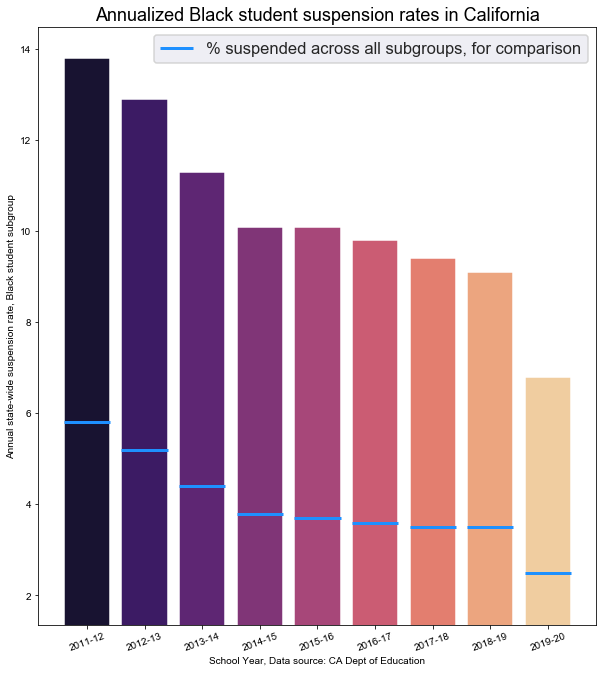

In [4]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_theme(style='darkgrid')
sns.set_context('talk')

make_graph('Black')


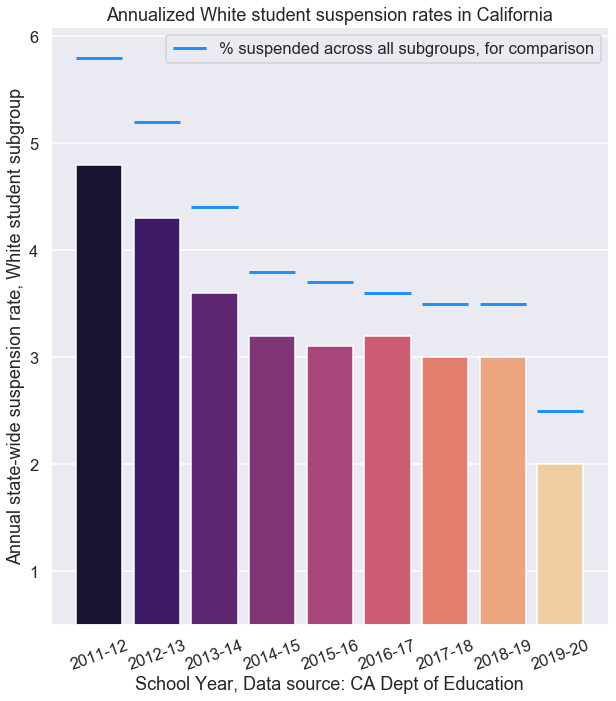

In [5]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_theme(style='darkgrid')
sns.set_context('talk')

make_graph('White')


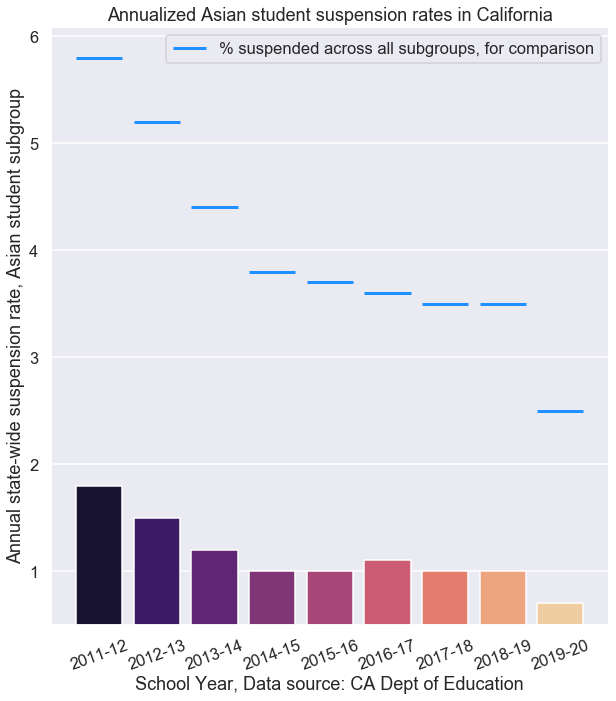

In [6]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_theme(style='darkgrid')
sns.set_context('talk')

make_graph('Asian')


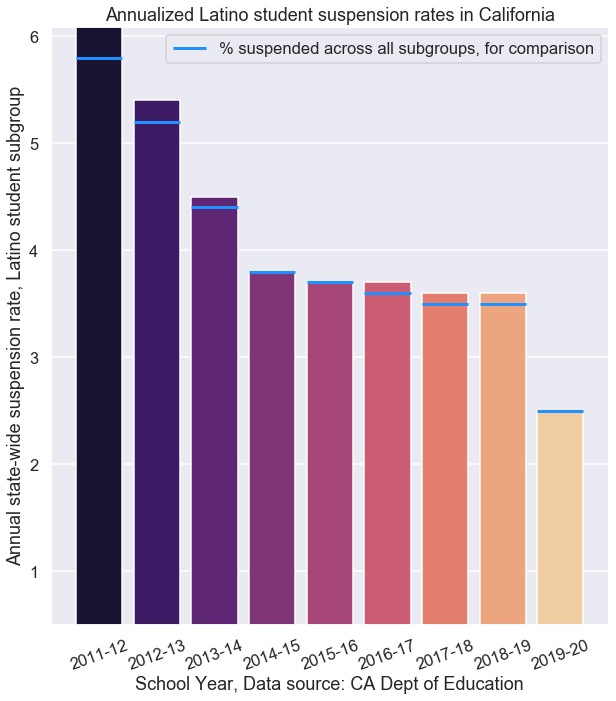

In [7]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_theme(style='darkgrid')
sns.set_context('talk')

make_graph('Latino')


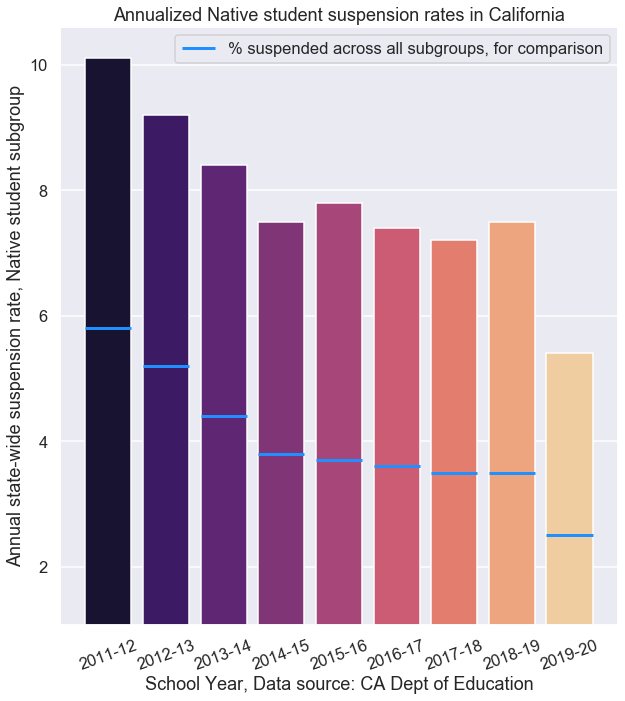

In [8]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_theme(style='darkgrid')
sns.set_context('talk')

make_graph('Native')


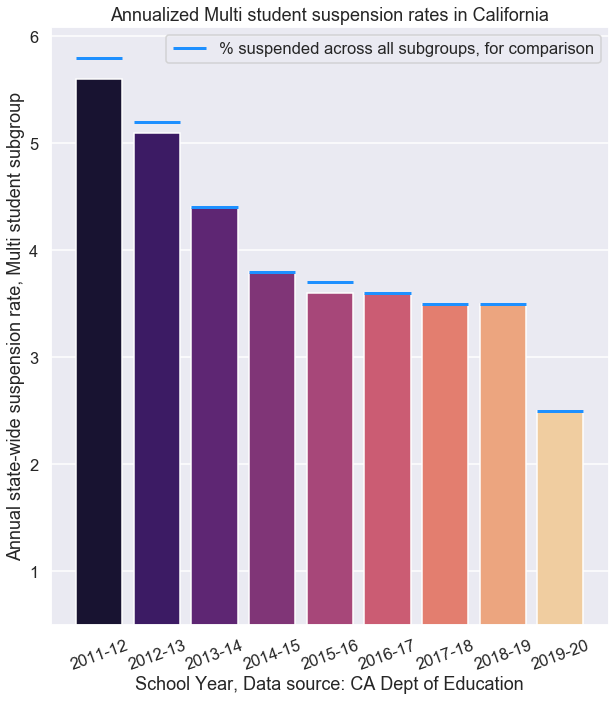

In [9]:
fig, ax = plt.subplots(figsize=(10,11))
sns.set_theme(style='darkgrid')
sns.set_context('talk')

make_graph('Multi')


## Endnotes:

1. This data includes data for all schools regardless of charter status (i.e. it includes both charter and non-charter schools in California)

2. The data on the percent of students disciplined displayed in the analysis above pertains to the number of **unique** students in each race/ethnicity subgroup that were suspended.

3. The data above pertains only to **suspensions.** According to the CA Dept of Education website where this data was taken from, the data on suspensions refers to total distinct count of all students suspended one or more times at the selected entity for the selected population using the available filters. Students who are suspended multiple times are only counted once.

